## SNR - fig1_convergence test

In [1]:
import time, datetime
import numpy as np
from numpy import zeros, sqrt, pi, vectorize
from numpy.linalg import pinv, inv
from multiprocessing import Process, Queue
#import matplotlib
#matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from error_analysis_class import *
from noshellavg import *
from matplotlib.backends.backend_pdf import PdfPages

In [9]:
def SNR_convergence_test(RSDPower, kmin = 0.001, kmax = 2, reverse = None, re = None):

    rcut_max = get_closest_index_in_data( RMAX, RSDPower.rmax )
    rcut_min = get_closest_index_in_data( RMIN, RSDPower.rmin )
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )

    file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
    RSDPower.MatterPower(file = file)
    # power spectrum multipoles l = 0,2,4
    RSDPower.multipole_P_band_all()

    # derivative dXi/dp
    RSDPower.derivative_Xi_band_all()

    # P covariance matrix ( nine submatrices C_ll' )
    RSDPower.RSDband_covariance_PP_all()

    # Xi covariance matrix ( nine submatrices C_ll' )
    RSDPower.covariance_Xi_all()
    RSDPower.covariance_PXi_All()


    matricesXi = [RSDPower.covariance00[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  np.transpose(RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
                  RSDPower.covariance22[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
                  np.transpose(RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
                  np.transpose(RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
                  RSDPower.covariance44[rcut_max:rcut_min+1,rcut_max:rcut_min+1]]

    matricesPP_all = [RSDPower.covariance_PP00,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP22,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP44]

    matricesPP = [RSDPower.covariance_PP00[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP22[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP44[kcut_min:kcut_max+1,kcut_min:kcut_max+1]]

    matricesPXi = [RSDPower.covariance_PXi00[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi02[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi04[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi20[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi22[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi24[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi40[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi42[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi44[kcut_min:kcut_max+1,rcut_max:rcut_min+1]]


    l1 = RSDPower.kcenter_y.size
    l2 = rcut_min+1 - rcut_max
    l3 = kcut_max+1 - kcut_min

    # combining covariances
    C_matrix3PP_all = CombineCovariance3(l1, matricesPP_all)
    C_matrix3PP = CombineCovariance3(l3, matricesPP)
    C_matrix3Xi = CombineCovariance3(l2, matricesXi)

    #C_matrix3PXi = np.zeros((C_matrix3PXi.shape))
    C_matrix3PXi, C_matrix3XiP = CombineCrossCovariance3(l3, l2, matricesPXi, transpose = True)
    C_matrix3_tot = np.concatenate((np.concatenate((C_matrix3PP, C_matrix3PXi), axis=1),\
                                    np.concatenate((C_matrix3PXi.T, C_matrix3Xi), axis=1)), axis = 0)



    # inverting matrices
    from test_SNR import blockwiseInversion
    FisherP_all = inv(C_matrix3PP_all)
    FisherP = inv(C_matrix3PP)
    FisherXi = blockwiseInversion( C_matrix3Xi, rcut_min+1-rcut_max )
    Fisher3_tot = blockwiseInversion( C_matrix3_tot, 3 * (kcut_max+1-kcut_min) )

    # derivatives
    derivative_P0 = np.identity(RSDPower.kcenter_y.size)[:,kcut_min:kcut_max+1]
    Pzeros = np.zeros((derivative_P0.shape))

    derivative_P = np.concatenate((np.concatenate((derivative_P0, Pzeros, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, derivative_P0, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, Pzeros, derivative_P0),axis=1 )), axis=0)
    Xizeros = np.zeros((RSDPower.dxip0[:,rcut_max:rcut_min+1].shape))
    derivative_correl_avg = np.concatenate(( np.concatenate((RSDPower.dxip0[:,rcut_max:rcut_min+1],Xizeros,Xizeros), axis=1),\
                                            np.concatenate((Xizeros,RSDPower.dxip2[:,rcut_max:rcut_min+1],Xizeros), axis=1),\
                                            np.concatenate((Xizeros,Xizeros,RSDPower.dxip4[:,rcut_max:rcut_min+1]), axis=1)),axis=0 )
    Derivatives = np.concatenate((derivative_P,derivative_correl_avg), axis=1)

    
    
    # Bandpower Fisher matrices from different estimators
    FisherBand_P = FisherP.copy()
    FisherBand_P_all = FisherP_all.copy()
    FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
    FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)
    
    
    from test_SNR import reorderingVector, reordering

    m_P0 = RSDPower.multipole_bandpower0[kcut_min:kcut_max+1]
    m_P2 = RSDPower.multipole_bandpower2[kcut_min:kcut_max+1]
    m_P4 = RSDPower.multipole_bandpower4[kcut_min:kcut_max+1]
    m_P = reorderingVector( [m_P0, m_P2, m_P4] )

    re_FisherBand_P_all, _ = reordering( RSDPower, FisherBand_P_all)
    re_FisherBand_P, _ = reordering( RSDPower, FisherBand_P)
    re_FisherBand_Xi, m_P_all = reordering( RSDPower, FisherBand_Xi)
    re_FisherBand_tot, _ = reordering( RSDPower, FisherBand_tot)

    
    if reverse == True:
        re_FisherBand_P = np.fliplr(np.rot90(re_FisherBand_P))
        re_FisherBand_P_all = np.fliplr(np.rot90(re_FisherBand_P_all))
        re_FisherBand_Xi = np.fliplr(np.rot90(re_FisherBand_Xi))
        re_FisherBand_tot = np.fliplr(np.rot90(re_FisherBand_tot))
        m_P = m_P[::-1]
        m_P_all = m_P_all[::-1]
    
    
    #P
    from test_SNR import blockwise

    FP = re_FisherBand_P_all.copy()
    PP = m_P_all.copy()

    SNRlist_P = []
    SNRP = np.dot( np.dot(PP, FP), PP.T )
    SNRlist_P.append(SNRP)
    for j in range(1, PP.size/3):
        PP = PP[:-3]
        for i in range(0,3):
            FP = blockwise( FP )
        SNRP = np.dot( np.dot(PP, FP), PP.T )
        SNRlist_P.append(SNRP)

    SNRlist_P = np.array(SNRlist_P[::-1]).ravel()
    kklist = RSDPower.kcenter_y#[kcut_min:kcut_max+1]

    # Xi

    F = re_FisherBand_Xi.copy()
    P = m_P_all.copy()

    SNRlist = []
    SNR = np.dot( np.dot(P, F), P.T )
    SNRlist.append(SNR)
    for j in range(1, P.size/3):
        P = P[:-3]
        for i in range(0,3):
            F = blockwise( F )
        SNR = np.dot( np.dot(P, F), P.T )
        SNRlist.append(SNR)

    SNRlist = np.array(SNRlist[::-1]).ravel()
    kklist2 = RSDPower.kcenter_y

    # tot

    Ft = re_FisherBand_tot.copy()
    Pt = m_P_all.copy()

    SNRlist_t = []
    SNRt = np.dot( np.dot(Pt, Ft), Pt.T )
    SNRlist_t.append(SNRt)
    for j in range(1, Pt.size/3):
        Pt = Pt[:-3]
        for i in range(0,3):
            Ft = blockwise( Ft )
        SNRt = np.dot( np.dot(Pt, Ft), Pt.T )
        SNRlist_t.append(SNRt)

    SNRlist_t = np.array(SNRlist_t[::-1]).ravel()
    #kklist2 = RSDPower.kcenter_y
    
    if reverse == True:
        kklist = kklist[::-1]
        kklist2 = kklist2[::-1]
        
    return RSDPower, kklist, SNRlist_P, kklist2, SNRlist, kklist2, SNRlist_t 

In [575]:
def BandPowerFisher(RSDPower, RMIN = 0.1, RMAX = 180, kmin = 0.001, kmax = 2, reorder=False):

    #RMAX = RSDPower.RMAX
    #RMIN = RSDPower.RMIN
    
    rcut_max = get_closest_index_in_data( RMAX, RSDPower.rmax )
    rcut_min = get_closest_index_in_data( RMIN, RSDPower.rmin )
    
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )   
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )
    
    print 'rcut_min, rcut_max ', RSDPower.rmax[rcut_min], RSDPower.rmin[rcut_max]
    
    file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
    RSDPower.MatterPower(file = file)
    # power spectrum multipoles l = 0,2,4
    RSDPower.multipole_P_band_all()

    # derivative dXi/dp
    RSDPower.derivative_Xi_band_all()

    # P covariance matrix ( nine submatrices C_ll' )
    RSDPower.RSDband_covariance_PP_all()

    # Xi covariance matrix ( nine submatrices C_ll' )
    RSDPower.covariance_Xi_all()
    RSDPower.covariance_PXi_All()


    matricesXi = [RSDPower.covariance00[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance22[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              np.transpose(RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance44[rcut_max:rcut_min+1,rcut_max:rcut_min+1]]

    matricesPP_all = [RSDPower.covariance_PP00,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP22,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP44]

    matricesPP = [RSDPower.covariance_PP00[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP22[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP44[kcut_min:kcut_max+1,kcut_min:kcut_max+1]]

    matricesPXi = [RSDPower.covariance_PXi00[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi02[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi04[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi20[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi22[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi24[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi40[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi42[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi44[kcut_min:kcut_max+1,rcut_max:rcut_min+1]]


    l1 = RSDPower.kcenter_y.size
    l2 = rcut_min+1 - rcut_max
    l3 = kcut_max+1 - kcut_min
    
    
    # combining covariances
    C_matrix3PP_all = CombineCovariance3(l1, matricesPP_all)
    C_matrix3PP = CombineCovariance3(l3, matricesPP)
    C_matrix3Xi = CombineCovariance3(l2, matricesXi)

    #C_matrix3PXi = np.zeros((C_matrix3PXi.shape))
    C_matrix3PXi, C_matrix3XiP = CombineCrossCovariance3(l3, l2, matricesPXi, transpose = True)
    C_matrix3_tot = np.concatenate((np.concatenate((C_matrix3PP, C_matrix3PXi), axis=1),\
                                    np.concatenate((C_matrix3PXi.T, C_matrix3Xi), axis=1)), axis = 0)


    
    # inverting matrices
    from test_SNR import blockwiseInversion
    FisherP_all = inv(C_matrix3PP_all)
    FisherP = inv(C_matrix3PP)
    FisherXi = blockwiseInversion( C_matrix3Xi, rcut_min+1-rcut_max )
    Fisher3_tot = blockwiseInversion( C_matrix3_tot, 3 * (kcut_max+1-kcut_min) )
    
    
    # derivatives
    derivative_P0 = np.identity(RSDPower.kcenter_y.size)[:,kcut_min:kcut_max+1]
    Pzeros = np.zeros((derivative_P0.shape))

    derivative_P = np.concatenate((np.concatenate((derivative_P0, Pzeros, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, derivative_P0, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, Pzeros, derivative_P0),axis=1 )), axis=0)
    Xizeros = np.zeros((RSDPower.dxip0[:,rcut_max:rcut_min+1].shape))
    derivative_correl_avg = np.concatenate(( np.concatenate((RSDPower.dxip0[:,rcut_max:rcut_min+1],Xizeros,Xizeros), axis=1),\
                                            np.concatenate((Xizeros,RSDPower.dxip2[:,rcut_max:rcut_min+1],Xizeros), axis=1),\
                                            np.concatenate((Xizeros,Xizeros,RSDPower.dxip4[:,rcut_max:rcut_min+1]), axis=1)),axis=0 )
    Derivatives = np.concatenate((derivative_P,derivative_correl_avg), axis=1)

    
    # Fisher.....
    FisherBand_P = FisherP.copy()
    FisherBand_P_all = FisherP_all.copy()
    FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
    FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)
    
    
    # vector and reorder
    from test_SNR import reorderingVector, reordering, blockwise
    m_P0 = RSDPower.multipole_bandpower0[kcut_min:kcut_max+1]
    m_P2 = RSDPower.multipole_bandpower2[kcut_min:kcut_max+1]
    m_P4 = RSDPower.multipole_bandpower4[kcut_min:kcut_max+1]
    m_P = reorderingVector( [m_P0, m_P2, m_P4] )
    # Fisher reorering
    re_FisherBand_P_all, _ = reordering( RSDPower, FisherBand_P_all)
    re_FisherBand_P, _ = reordering( RSDPower, FisherBand_P)
    re_FisherBand_Xi, m_P_all = reordering( RSDPower, FisherBand_Xi)
    re_FisherBand_tot, _ = reordering( RSDPower, FisherBand_tot)

    #if reorder is False : return [m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi]
    #elif reorder is True : return m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot
    
    return [m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi], m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot

In [11]:
def BandPowerFisher(RSDPower, RMIN = 0.1, RMAX = 180, kmin = 0.001, kmax = 2, reorder=False):

    #RMAX = RSDPower.RMAX
    #RMIN = RSDPower.RMIN
    
    rcut_max = get_closest_index_in_data( RMAX, RSDPower.rmax )
    rcut_min = get_closest_index_in_data( RMIN, RSDPower.rmin )
    
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )   
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )
    
    print 'rcut_min, rcut_max ', RSDPower.rmax[rcut_min], RSDPower.rmin[rcut_max]
    
    file = 'matterpower_z_0.55.dat'  # from camb (z=0.55)
    RSDPower.MatterPower(file = file)
    # power spectrum multipoles l = 0,2,4
    RSDPower.multipole_P_band_all()

    # derivative dXi/dp
    RSDPower.derivative_Xi_band_all()

    # P covariance matrix ( nine submatrices C_ll' )
    RSDPower.RSDband_covariance_PP_all()

    # Xi covariance matrix ( nine submatrices C_ll' )
    RSDPower.covariance_Xi_all()
    RSDPower.covariance_PXi_All()


    matricesXi = [RSDPower.covariance00[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance02[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance22[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1],\
              np.transpose(RSDPower.covariance04[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              np.transpose(RSDPower.covariance24[rcut_max:rcut_min+1,rcut_max:rcut_min+1]),\
              RSDPower.covariance44[rcut_max:rcut_min+1,rcut_max:rcut_min+1]]

    matricesPP_all = [RSDPower.covariance_PP00,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP02,\
                    RSDPower.covariance_PP22,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP04,RSDPower.covariance_PP24,\
                    RSDPower.covariance_PP44]

    matricesPP = [RSDPower.covariance_PP00[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP02[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP22[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP04[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP24[kcut_min:kcut_max+1,kcut_min:kcut_max+1],
                RSDPower.covariance_PP44[kcut_min:kcut_max+1,kcut_min:kcut_max+1]]

    matricesPXi = [RSDPower.covariance_PXi00[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi02[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi04[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi20[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi22[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi24[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi40[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi42[kcut_min:kcut_max+1,rcut_max:rcut_min+1],\
                 RSDPower.covariance_PXi44[kcut_min:kcut_max+1,rcut_max:rcut_min+1]]


    l1 = RSDPower.kcenter_y.size
    l2 = rcut_min+1 - rcut_max
    l3 = kcut_max+1 - kcut_min
    
    
    # combining covariances
    C_matrix3PP_all = CombineCovariance3(l1, matricesPP_all)
    C_matrix3PP = CombineCovariance3(l3, matricesPP)
    C_matrix3Xi = CombineCovariance3(l2, matricesXi)

    #C_matrix3PXi = np.zeros((C_matrix3PXi.shape))
    C_matrix3PXi, C_matrix3XiP = CombineCrossCovariance3(l3, l2, matricesPXi, transpose = True)
    C_matrix3_tot = np.concatenate((np.concatenate((C_matrix3PP, C_matrix3PXi), axis=1),\
                                    np.concatenate((C_matrix3PXi.T, C_matrix3Xi), axis=1)), axis = 0)


    
    # inverting matrices
    from test_SNR import blockwiseInversion
    FisherP_all = inv(C_matrix3PP_all)
    FisherP = inv(C_matrix3PP)
    FisherXi = blockwiseInversion( C_matrix3Xi, rcut_min+1-rcut_max )
    Fisher3_tot = blockwiseInversion( C_matrix3_tot, 3 * (kcut_max+1-kcut_min) )
    
    
    # derivatives
    derivative_P0 = np.identity(RSDPower.kcenter_y.size)[:,kcut_min:kcut_max+1]
    Pzeros = np.zeros((derivative_P0.shape))

    derivative_P = np.concatenate((np.concatenate((derivative_P0, Pzeros, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, derivative_P0, Pzeros),axis=1 ),\
                                   np.concatenate((Pzeros, Pzeros, derivative_P0),axis=1 )), axis=0)
    Xizeros = np.zeros((RSDPower.dxip0[:,rcut_max:rcut_min+1].shape))
    derivative_correl_avg = np.concatenate(( np.concatenate((RSDPower.dxip0[:,rcut_max:rcut_min+1],Xizeros,Xizeros), axis=1),\
                                            np.concatenate((Xizeros,RSDPower.dxip2[:,rcut_max:rcut_min+1],Xizeros), axis=1),\
                                            np.concatenate((Xizeros,Xizeros,RSDPower.dxip4[:,rcut_max:rcut_min+1]), axis=1)),axis=0 )
    Derivatives = np.concatenate((derivative_P,derivative_correl_avg), axis=1)

    
    # Fisher.....
    FisherBand_P = FisherP.copy()
    FisherBand_P_all = FisherP_all.copy()
    FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
    FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)
    
    
    # vector and reorder
    from test_SNR import reorderingVector, reordering, blockwise
    m_P0 = RSDPower.multipole_bandpower0[kcut_min:kcut_max+1]
    m_P2 = RSDPower.multipole_bandpower2[kcut_min:kcut_max+1]
    m_P4 = RSDPower.multipole_bandpower4[kcut_min:kcut_max+1]
    m_P = reorderingVector( [m_P0, m_P2, m_P4] )
    # Fisher reorering
    re_FisherBand_P_all, _ = reordering( RSDPower, FisherBand_P_all)
    re_FisherBand_P, _ = reordering( RSDPower, FisherBand_P)
    re_FisherBand_Xi, m_P_all = reordering( RSDPower, FisherBand_Xi)
    re_FisherBand_tot, _ = reordering( RSDPower, FisherBand_tot)

    #if reorder is False : return [m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi]
    #elif reorder is True : return m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot
    
    return [m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi], m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot

In [10]:
def CumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kmin, kmax):
    
    from test_SNR import blockwise
    
    kcut_min = get_closest_index_in_data( kmin, RSDPower.kmin_y )
    kcut_max = get_closest_index_in_data( kmax, RSDPower.kmax_y )

    FP = re_FisherBand_P_all.copy()[3*kcut_min:3*kcut_max+3, 3*kcut_min:3*kcut_max+3]
    PP = m_P_all.copy()[3*kcut_min:3*kcut_max+3]
    
    SNRlist_P = []
    SNRP = np.dot( np.dot(PP, FP), PP.T )
    SNRlist_P.append(SNRP)
    for j in range(1, PP.size/3):
        PP = PP[:-3]
        for i in range(0,3):
            FP = blockwise( FP )
        SNRP = np.dot( np.dot(PP, FP), PP.T )
        SNRlist_P.append(SNRP)

    SNRlist_P = np.array(SNRlist_P[::-1]).ravel()
    kklist = RSDPower.kcenter_y[kcut_min:kcut_max+1]
    
    return kklist, SNRlist_P

#### Band-power Fisher matrixes from different estimators

In [488]:
#FisherBand_P = FisherP.copy()
#FisherBand_P_all = FisherP_all.copy()
#FisherBand_Xi = FisherProjection_Fishergiven(derivative_correl_avg, FisherXi)
#FisherBand_tot = FisherProjection_Fishergiven(Derivatives, Fisher3_tot)

## Initial settings 

In [6]:
#  (parameter description in class code)
# Fourier K 0.001~10
KMIN = 1e-10
KMAX = 2 # 361.32 #502.32
RMIN = 1e-10
RMAX = 200

kmin = 0.01
kmax = 0.2

# the number of k sample point should be 2^n+1 (b/c romb integration)
rN = 500 # (RMAX-int(RMIN)) * 2
kN = 1
kN_x = 2**13 + 1
kN_y = 500
#subN = 2**5 + 1
# RSD class

In [13]:
RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, kN_y, logscale = False)

-------------------------------------------------------------------        
class error_analysis, no RSD         
z = 0.0, kN =1, N_y = 500, rN = 500
dr = 0.400801603206, dk=nan, dk_y=0.00400801603186


In [14]:
[m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi], m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot \
= BandPowerFisher(RSDPower, RMIN = RMIN, RMAX = RMAX, kmin = kmin, kmax = kmax)

rcut_min, rcut_max  0.400801603306 199.599198397


/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))
/n/home00/lee.5922/.local/lib/python2.7/site-packages/scipy/integrate/quadrature.py:392: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = x.reshape(tuple(shapex))


multiprocessing 100 %

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
#RSDPower = NoShell_covariance(KMIN, KMAX, RMIN, RMAX, kN, rN, kN_x, kN_y, logscale = False)
#_, kbin, SNR_P, kbin2, SNR_Xi, kbin2, SNR_tot = SNR_convergence_test(RSDPower)
#m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot = \
#BandPowerFisher(RSDPower, RMIN = RMIN, RMAX = RMAX, kmin = kmin, kmax = kmax, reorder = True)
#[m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi] = \
#BandPowerFisher(RSDPower, RMIN = RMIN, RMAX = RMAX, kmin = kmin, kmax = kmax)

[m_P0, m_P2, m_P4], [FisherBand_P, FisherBand_Xi], m_P, m_P_all, re_FisherBand_P_all,re_FisherBand_P, re_FisherBand_Xi, re_FisherBand_tot \
= BandPowerFisher(RSDPower, RMIN = RMIN, RMAX = RMAX, kmin = kmin, kmax = kmax)

kbin, SNR_P = CumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kmin, kmax)
kbin2, SNR_Xi = CumulativeSNR(RSDPower, re_FisherBand_Xi, m_P_all, KMIN, KMAX)
kbin_tot, SNR_tot = CumulativeSNR(RSDPower, re_FisherBand_tot, m_P_all, KMIN, KMAX)
kbin_d, DiagCSNR_P, DiagCSNR_Xi =  CumulativeSNR_diag( FisherBand_P, FisherBand_Xi, data_vec = [m_P0, m_P2, m_P4])

In [ ]:
k_s, SNR_P_s = CumulativeSNR(RSDPower, re_FisherBand_P_all, m_P_all, kmin, kmax)
DAT = np.column_stack((k_s, SNR_P_s ))
#np.savetxt('data_txt/snr.txt', DAT)
#np.savetxt('data_txt/snr_kmax'+str(kmax)+'_kmin'+str(kmin)+'.txt', DAT)

In [ ]:
kcolumn = np.zeros(kbin2.size)
SNR_P_column = kcolumn.copy()
kcolumn[:kbin.size] = kbin
SNR_P_column[:kbin.size] = SNR_P
DAT = np.column_stack((kcolumn, SNR_P_column, kbin2, SNR_Xi ))
#np.savetxt('data_txt/snr.txt', DAT)
np.savetxt('data_txt/snr_rmax'+str(RMAX)+'_rmin'+str(RMIN)+'.txt', DAT)

# kbin_tot, SNR_tot
DAT = np.column_stack((kbin_tot, SNR_tot ))
#np.savetxt('data_txt/snr.txt', DAT)
np.savetxt('data_txt/snr_tot_rmax'+str(RMAX)+'_rmin'+str(RMIN)+'_kmax'+str(kmax)+'_kmin'+str(kmin)+'.txt', DAT)

#kbin_d, DiagCSNR_P, DiagCSNR_Xi =  CumulativeSNR_diag( FisherBand_P, FisherBand_Xi, data_vec = [m_P0, m_P2, m_P4])
# diagonal data
#DAT = np.column_stack((kbin_d, DiagCSNR_P, DiagCSNR_Xi ))
#np.savetxt('data_txt/snr_diag_rmax'+str(RMAX)+'_rmin'+str(RMIN)+'.txt', DAT)

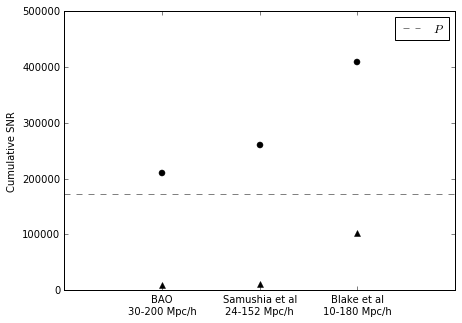

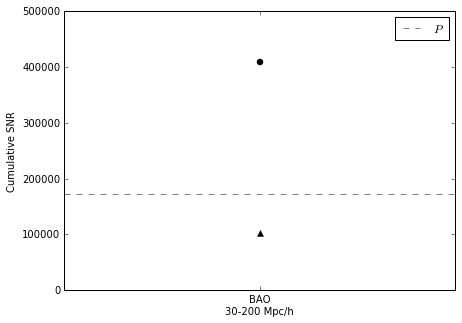

In [149]:
r_range = [['200', '30'], ['152', '24'], ['180', '10']]


fig, ax = plt.subplots(1,1, figsize = (7, 5))
for j, r in enumerate(r_range):
    D1 = np.loadtxt('data_txt/snr_rmax'+r[0]+'_rmin'+r[1]+'.txt')
    D2 = np.loadtxt('data_txt/snr_tot_rmax'+r[0]+'_rmin'+r[1]+'_kmax0.2_kmin0.01.txt')
    
    _, _, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
    kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    
    
    ax.plot(j, SNR_Xi[-1], marker='^', color = 'black')
    ax.plot(j, SNR_tot[-1], marker = 'o', color = ax.lines[-1].get_color())
    #ax.plot(kbin2, SNR_Xi, '--')
    #ax.plot(kbin_tot, SNR_tot, linestyle = '-', color = ax.lines[-1].get_color())

D3 = np.loadtxt('data_txt/snr_kmax0.2_kmin0.01.txt')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
ax.axhline( y = SNR_P[-1], linestyle='--', color = 'grey', label = r'$P$')
ax.set_ylim(0,500000)
ax.set_xlim(-1, j+1)
ax.set_xticks(np.arange(-1, j+1))
ax.set_xticklabels(['', 'BAO\n30-200 Mpc/h', 'Samushia et al\n24-152 Mpc/h', 'Blake et al\n10-180 Mpc/h'])
ax.legend(loc='best')
ax.set_ylabel('Cumulative SNR')
    
r_range = [['180', '10']]

fig, ax = plt.subplots(1,1, figsize = (7, 5))
for j, r in enumerate(r_range):
    D1 = np.loadtxt('data_txt/snr_rmax'+r[0]+'_rmin'+r[1]+'.txt')
    D2 = np.loadtxt('data_txt/snr_tot_rmax'+r[0]+'_rmin'+r[1]+'_kmax0.2_kmin0.01.txt')
    
    _, _, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
    kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    
    
    ax.plot(j, SNR_Xi[-1], marker='^', color = 'black')
    ax.plot(j, SNR_tot[-1], marker = 'o', color = ax.lines[-1].get_color())
    #ax.plot(kbin2, SNR_Xi, '--')
    #ax.plot(kbin_tot, SNR_tot, linestyle = '-', color = ax.lines[-1].get_color())

D3 = np.loadtxt('data_txt/snr_kmax0.2_kmin0.01.txt')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
ax.axhline( y = SNR_P[-1], linestyle='--', color = 'grey', label = r'$P$')
ax.set_ylim(0,500000)
ax.set_xlim(-1, j+1)
ax.set_xticks(np.arange(-1, j+1))
ax.set_xticklabels(['','BAO\n30-200 Mpc/h', 'Samushia et al\n24-152 Mpc/h', 'Blake et al\n10-180 Mpc/h'])
ax.legend(loc='best')
ax.set_ylabel('Cumulative SNR')

----

(0, 600000)

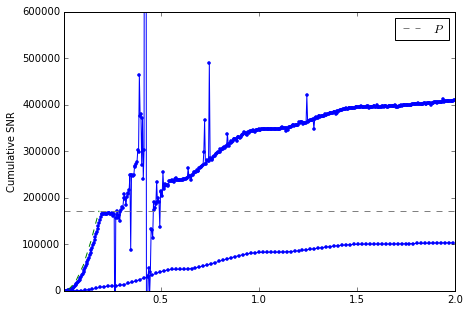

In [150]:
fig, ax = plt.subplots(1,1, figsize = (7, 5))
for j, r in enumerate(r_range):
    D1 = np.loadtxt('data_txt/snr_rmax'+r[0]+'_rmin'+r[1]+'.txt')
    D2 = np.loadtxt('data_txt/snr_tot_rmax'+r[0]+'_rmin'+r[1]+'_kmax0.2_kmin0.01.txt')
    
    _, _, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]
    kbin_tot, SNR_tot = [D2[:,i] for i in range(D2[0,:].size)]    
    
    ax.plot(kbin2, SNR_Xi, marker='.')
    ax.plot(kbin_tot, SNR_tot, marker = '.', color = ax.lines[-1].get_color())
    #ax.plot(kbin2, SNR_Xi, '--')
    #ax.plot(kbin_tot, SNR_tot, linestyle = '-', color = ax.lines[-1].get_color())

D3 = np.loadtxt('data_txt/snr_kmax0.2_kmin0.01.txt')
kbin, SNR_P = [D3[:,i] for i in range(D3[0,:].size)]
ax.plot(kbin, SNR_P, '--')
ax.axhline( y = SNR_P[-1], linestyle='--', color = 'grey', label = r'$P$')
ax.legend(loc='best')
#ax.set_xscale('log')
ax.set_xlim(0.01, 2)
ax.set_ylabel('Cumulative SNR')
ax.set_ylim(0, 600000)